##### Copyright 2019 The TensorFlow Authors.

Este tutorial está basado en:

https://www.tensorflow.org/tutorials/images/segmentation

# Segmentación semántica

Este tutorial se centra en la tarea de segmentación de imágenes, utilizando una red <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a> modificada.

## ¿Qué es la segmentación semántica de imágenes?

En una tarea de clasificación de imágenes, la red asigna una etiqueta (o clase) a cada imagen de entrada. Sin embargo, supongamos que quieres saber la forma de ese objeto, qué píxel pertenece a qué objeto, etc. En este caso, es necesario asignar una clase a cada píxel de la imagen: esta tarea se conoce como segmentación semántica. Un modelo de segmentación semántica devuelve información mucho más detallada sobre la imagen. La segmentación semántica de imágenes tiene muchas aplicaciones en imágenes médicas, automóviles autónomos e imágenes por satélite, por nombrar sólo algunas.

Este tutorial utiliza el [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)). El conjunto de datos consta de imágenes de 37 razas de mascotas, con 200 imágenes por raza (~100 cada una en las divisiones de entrenamiento y prueba). Cada imagen incluye las etiquetas correspondientes y máscaras de píxeles. Las máscaras son etiquetas de clase para cada píxel. A cada píxel se le asigna una de tres categorías:

- Clase 1: píxel que pertenece a la mascota.
- Clase 2: Píxel que limita con la mascota.
- Clase 3: Ninguno de los anteriores/un píxel circundante.

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Descargar el conjunto de datos Oxford-IIIT Pets

El conjunto de datos está [disponible en TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). Las máscaras de segmentación se incluyen en la versión 3+.

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Además, los valores de color de la imagen se normalizan al rango `[0, 1]`. Por último, como se ha mencionado anteriormente, los píxeles de la máscara de segmentación se etiquetan como {1, 2, 3}. En aras de la conveniencia, restar 1 de la máscara de segmentación, lo que resulta en las etiquetas que son : {0, 1, 2}.

In [4]:
def normalize(input_image, input_mask):
  # Convertir la imagen de entrada a tipo float32 y normalizar los valores de píxeles entre 0 y 1
  input_image = tf.cast(input_image, tf.float32) / 255.0

  # Restar 1 a la máscara de entrada
  input_mask -= 1

  # Devolver la imagen de entrada normalizada y la máscara de entrada modificada
  return input_image, input_mask


In [5]:
def load_image(datapoint):
  # Redimensionar la imagen de entrada a 128x128 píxeles
  input_image = tf.image.resize(datapoint['image'], (128, 128))

  # Redimensionar la máscara de segmentación de entrada a 128x128 píxeles
  # Utilizando el método de vecino más cercano para mantener la precisión de las etiquetas
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  # Normalizar la imagen y ajustar la máscara de segmentación
  input_image, input_mask = normalize(input_image, input_mask)

  # Devolver la imagen de entrada normalizada y la máscara de segmentación ajustada
  return input_image, input_mask

El conjunto de datos ya contiene las divisiones de entrenamiento y prueba necesarias, así que sigamos utilizando las mismas divisiones:

In [6]:
# Obtener la longitud del conjunto de entrenamiento, que es el número total de ejemplos de entrenamiento disponibles
TRAIN_LENGTH = info.splits['train'].num_examples

# Tamaño del lote utilizado durante el entrenamiento del modelo
BATCH_SIZE = 64

# Tamaño del búfer utilizado para mezclar aleatoriamente los datos de entrenamiento antes de cada época
BUFFER_SIZE = 1000

# Número de pasos (batches) que se realizarán en cada época de entrenamiento
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


In [7]:
# num_parallel_calls=tf.data.AUTOTUNE permite que TensorFlow ajuste dinámicamente el número de hilos de ejecución

# Cargar y transformar las imágenes del conjunto de entrenamiento utilizando la función load_image
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Cargar y transformar las imágenes del conjunto de prueba utilizando la función load_image
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


La siguiente clase realiza un aumento simple volteando aleatoriamente una imagen.

Visite el tutorial [Image augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) para obtener más información.

La siguiente celda define una nueva clase `Augment` que hereda de `tf.keras.layers.Layer`. Esta clase se utilizará para realizar aumentos de datos (data augmentation) en las entradas y etiquetas de un modelo de IA.

In [8]:


class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    # Aplicar la operación de aumento (augmentation) a las entradas (inputs)
    inputs = self.augment_inputs(inputs)
    # Aplicar la operación de aumento (augmentation) a las etiquetas (labels)
    labels = self.augment_labels(labels)
    return inputs, labels


Construir el pipeline de entrada, aplicando el aumento tras la división en lotes (*batching*) de las entradas:

In [9]:
# Crear lotes de datos de entrenamiento con aumento de datos (data augmentation)
train_batches = (
    train_images  # Conjunto de imágenes de entrenamiento cargadas y transformadas
    .cache()  # Almacenar en caché los datos para acelerar el acceso
    .shuffle(BUFFER_SIZE)  # Mezclar los datos con un tamaño de búfer especificado
    .batch(BATCH_SIZE)  # Agrupar los datos en lotes del tamaño especificado
    .repeat()  # Repetir indefinidamente los datos para múltiples épocas de entrenamiento
    .map(Augment())  # Aplicar aumento de datos utilizando la clase Augment definida anteriormente
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Precargar datos para acelerar la ejecución
)

# Crear lotes de datos de prueba sin aumento de datos
test_batches = test_images.batch(BATCH_SIZE)

Visualizar un ejemplo de imagen y su máscara correspondiente a partir del conjunto de datos:

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

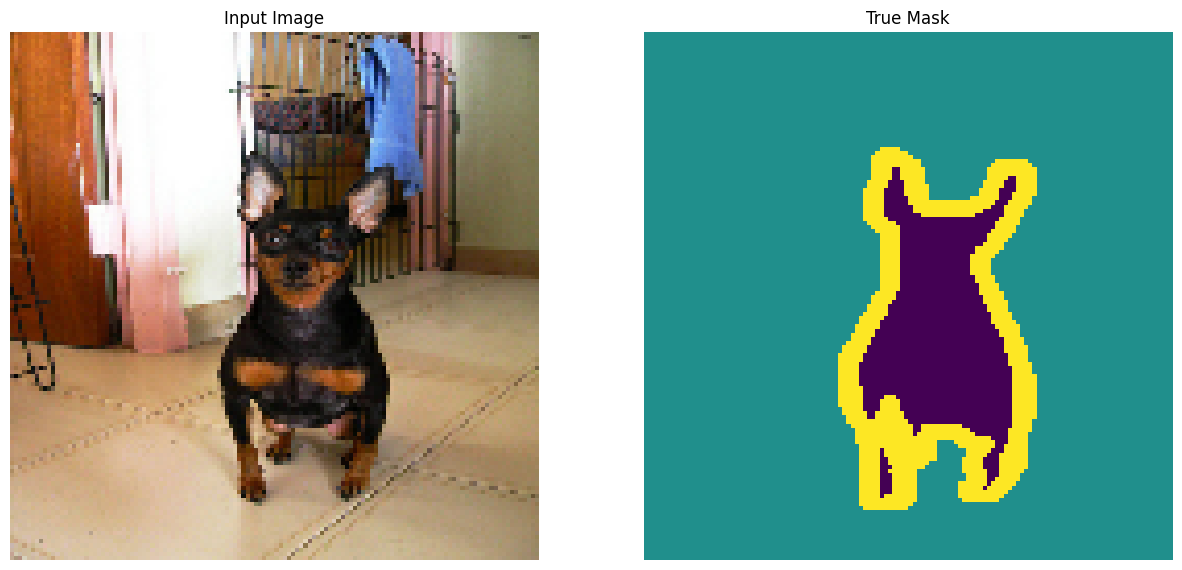

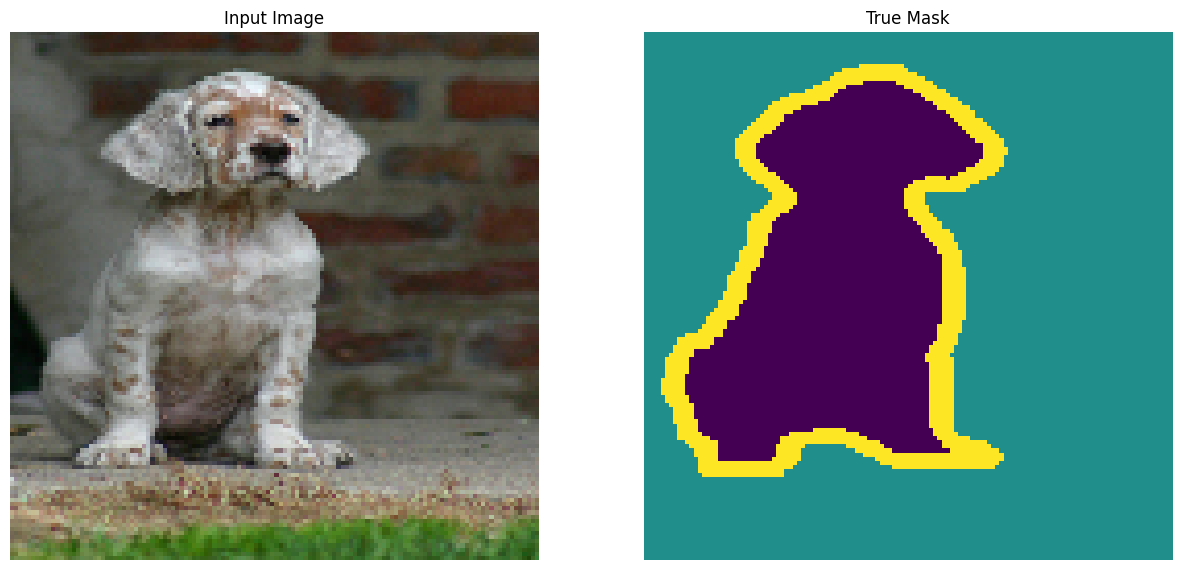

In [11]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Definir el modelo
El modelo que se utiliza aquí es una [U-Net] modificada (https://arxiv.org/abs/1505.04597). Una U-Net consiste en un codificador (downsampler) y un decodificador (upsampler). Para aprender características robustas y reducir el número de parámetros entrenables, utiliza un modelo preentrenado -[MobileNetV2](https://arxiv.org/abs/1801.04381)- como codificador. Para el decodificador, utiliza el bloque upsample, que ya está implementado en el ejemplo [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) del repositorio de ejemplos de TensorFlow. (Echa un vistazo al tutorial [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb)).


Como se ha mencionado, el codificador es un modelo MobileNetV2 preentrenado. Utiliza el modelo de `tf.keras.applications`. El codificador consiste en salidas específicas de las capas intermedias del modelo. Tenga en cuenta que el codificador no será entrenado durante el proceso de entrenamiento.

In [12]:
# Cargar el modelo base MobileNetV2 preentrenado en ImageNet, sin incluir la capa densa (fully connected) superior
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Utilizar las activaciones de estas capas para la extracción de características
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

# Obtener las salidas de las capas especificadas por layer_names del modelo base
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Crear el modelo de extracción de características usando las capas obtenidas como salidas
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Establecer el modelo base como no entrenable (congelar los pesos preentrenados)
down_stack.trainable = False


El decodificador/upsampler es simplemente una serie de bloques de upsample implementados en ejemplos de TensorFlow:

In [13]:
# Definir una secuencia de capas de upsampling (aumento de tamaño)
up_stack = [
    pix2pix.upsample(512, 3),  # Aumentar de 4x4 a 8x8 píxeles
    pix2pix.upsample(256, 3),  # Aumentar de 8x8 a 16x16 píxeles
    pix2pix.upsample(128, 3),  # Aumentar de 16x16 a 32x32 píxeles
    pix2pix.upsample(64, 3),   # Aumentar de 32x32 a 64x64 píxeles
]


In [14]:
def unet_model(output_channels: int):
  # Definir la entrada del modelo
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling a través del modelo
  skips = down_stack(inputs)  # Aplicar el modelo de extracción de características (down_stack) a las entradas
  x = skips[-1]  # Tomar la última salida de las capas de downsampling como entrada inicial para el upsampling
  skips = reversed(skips[:-1])  # Revertir y seleccionar todas las salidas excepto la última como skips

  # Upsampling y establecimiento de conexiones de skip
  for up, skip in zip(up_stack, skips):
    x = up(x)  # Aplicar cada capa de upsampling (up_stack) a la salida actual (x)
    concat = tf.keras.layers.Concatenate()  # Capa para concatenar características de upsampling y skip
    x = concat([x, skip])  # Concatenar la salida de upsampling con el skip correspondiente

  # Esta es la última capa del modelo
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  # Convolución transpuesta para aumentar el tamaño de la imagen

  x = last(x)  # Aplicar la convolución transpuesta a la salida actual (x)

  # Crear y devolver el modelo U-Net completo
  return tf.keras.Model(inputs=inputs, outputs=x)


Tenga en cuenta que el número de filtros en la última capa se establece en el número de `output_channels`. Esto será un canal de salida por clase.

## Entrenar el modelo

Ahora, todo lo que queda por hacer es compilar y entrenar el modelo.

Dado que se trata de un problema de clasificación multiclase, utiliza la función de pérdida `tf.keras.losses.SparseCategoricalCrossentropy` con el argumento `from_logits` a `True`, ya que las etiquetas son enteros escalares en lugar de vectores de puntuaciones para cada píxel de cada clase.

Cuando se ejecuta la inferencia, la etiqueta asignada al píxel es el canal con el valor más alto. Esto es lo que hace la función `create_mask`.

In [15]:
OUTPUT_CLASSES = 3  # Número de clases de salida del modelo

# Crear el modelo U-Net utilizando la función definida previamente
model = unet_model(output_channels=OUTPUT_CLASSES)

# Compilar el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Trazar la arquitectura del modelo resultante:

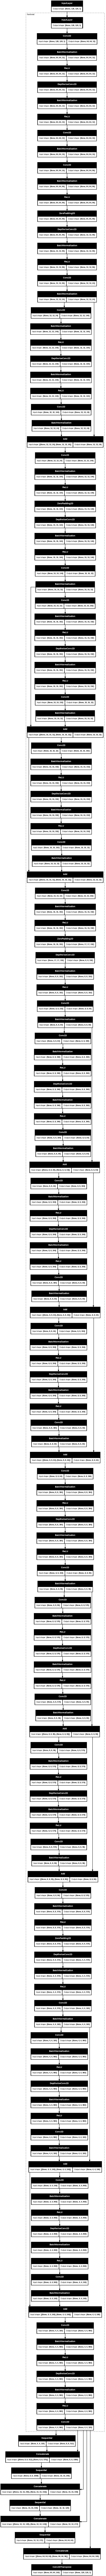

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

Probar el modelo para comprobar lo que predice antes del entrenamiento:

In [17]:
def create_mask(pred_mask):
  # Encontrar el índice con el valor máximo a lo largo del último eje
  pred_mask = tf.math.argmax(pred_mask, axis=-1)

  # Agregar una nueva dimensión al final del tensor
  pred_mask = pred_mask[..., tf.newaxis]

  # Seleccionar la primera máscara predicha
  return pred_mask[0]

In [18]:
def show_predictions(dataset=None, num=1):
  if dataset:
    # Iterar sobre el dataset y mostrar las predicciones para un número específico de ejemplos
    for image, mask in dataset.take(num):
      # Predecir la máscara utilizando el modelo
      pred_mask = model.predict(image)
      # Mostrar las imágenes original, la máscara real y la máscara predicha
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    # Mostrar las predicciones para un ejemplo único (usando datos de muestra)
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


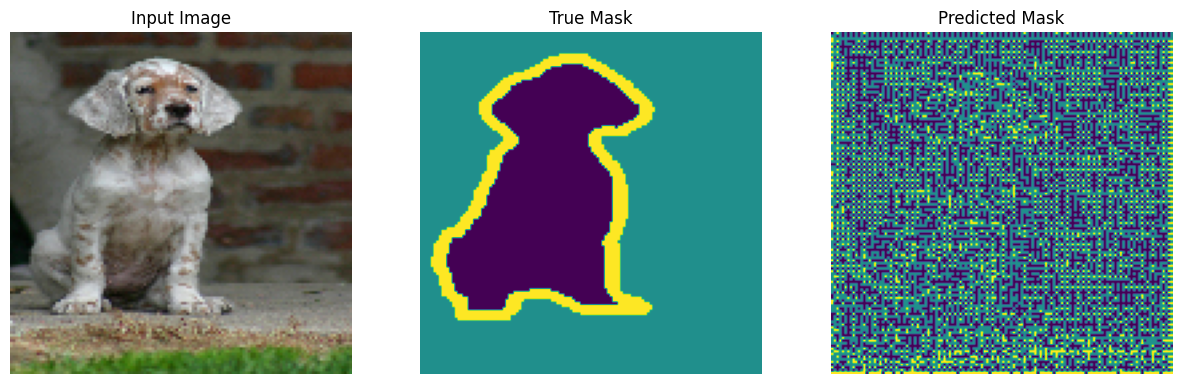

In [19]:
show_predictions()

La llamada de retorno (*callback*) definida a continuación se utiliza para observar cómo mejora el modelo mientras se entrena:

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)  # Limpiar la salida para mostrar la siguiente predicción
    show_predictions()  # Mostrar las predicciones después de cada época
    print('\nPredicción de ejemplo después de la época {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


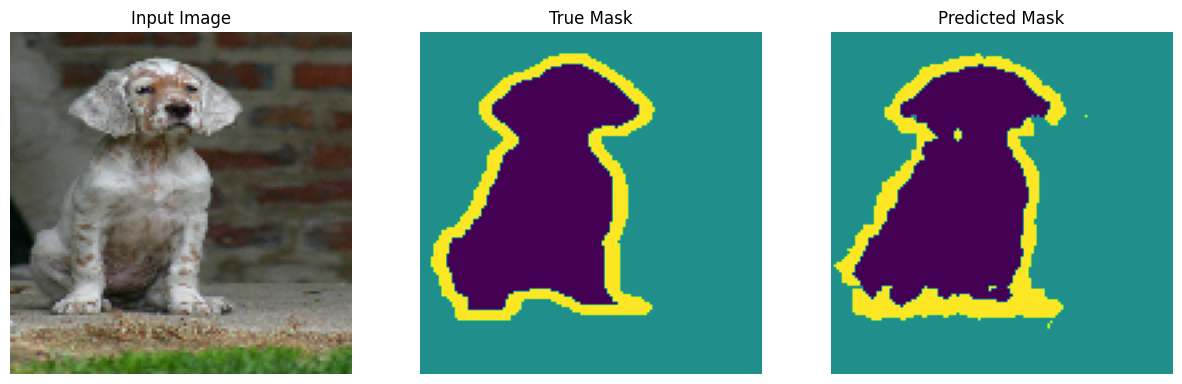


Predicción de ejemplo después de la época 30

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.9436 - loss: 0.1358 - val_accuracy: 0.9030 - val_loss: 0.2969


In [21]:
# Para ahorrar tiempo, el número de épocas se ha mantenido pequeño, pero podemos aumentarlo para obtener resultados más precisos.
EPOCHS = 30  # Número de épocas para entrenar el modelo
VAL_SUBSPLITS = 5  # Número de subconjuntos para la validación
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS  # Pasos de validación por época

# Entrenar el modelo y guardar el historial del entrenamiento
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])


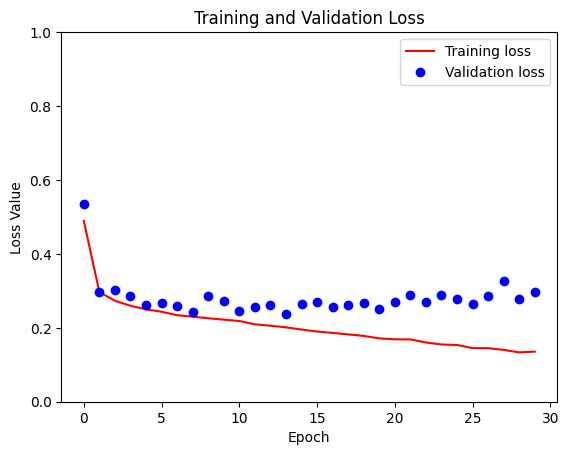

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Hacer predicciones

Ahora, hagamos algunas predicciones.

In [23]:
show_predictions(test_batches, 10)

Output hidden; open in https://colab.research.google.com to view.

## Siguientes pasos

Ahora que ya sabes qué es la segmentación semántica y cómo funciona, puedes probar este tutorial con diferentes resultados de capas intermedias, o incluso con diferentes modelos preentrenados. También puedes desafiarte a ti mismo probando el desafío de enmascaramiento de imágenes [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) alojado en Kaggle.

También puedes ver [Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md) para otro modelo que puedes reentrenar en tus propios datos. Los modelos preentrenados están disponibles en [TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection#optional).